<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 25</font></b></strong>

<strong><b><font size="4">Otimização de Hiperparâmetros em Modelos de Deep Learning Para Previsão Mensal de Vendas</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

Criamos alguns modelos de Deep Learning até aqui para prever nossa série temporal, mas não tivemos resultados realmente diferenciados. A vida como ela é na prática. Não espere mágica, isso não existe. O que existe é conhecimento e trabalho duro, assim que conquistamos resultados.

Os modelos de Deep Learning não tem alcançado boa performance por uma razão simples: nosso conjunto de dados é pequeno. Deep Learning mostra seu brilho quando temos um volume de dados realmente grande (aquele tal de Big Data).

Poderíamos, claro, trabalhar com a nossa série de vendas diárias e assim teríamos um volume de dados muito maior. Mas ao decidir trabalhar com a série da média mensal, precisaríamos de um volume de dados pelo menos 10x maior. Isso fica evidente pelos resultados similares em quase todos os modelos que criamos até aqui (com ou sem Deep Learning). Trabalhar com séries mensais é sempre um grande desafio e pode não ser a melhor opção.

E por que trabalhamos com a média mensal e não as vendas diárias? Porque nosso objetivo neste curso era mostrar não apenas ferramentas e análise, mas as dificuldades inerentes ao processo, quando uma série é difícil de ajustar ou o volume de dados é pequeno. Dependendo do problema podemos não alcançar um resultado satisfatório. É assim que as coisas funcionam na vida real.

**Mas vamos para mais uma tentativa. O trabalho em Data Science passa por experimentação e podemos experimentar outras abordagens e comparar os resultados.**

Como diria Rocky Balboa: "Mais um round, por favor!"

Nesta aula vamos aplicar uma mudança na preparação dos dados e criar um modelo LSTM Bidirectional (uma das arquiteturas de Deep Learning mais avançadas quando trabalhamos com séries usando modelos LSTM) e depois aplicar Grid Search para otimizar os hiperparâmetros do modelo e criar a versão final.

Já posso antecipar: será a melhor versão dos modelos de Deep Learning que criamos até aqui.

Resumindo o que faremos nesta aula:
    
- Removeremos os picos de vendas da série original.
- Criaremos a primeira versão do modelo LSTM Bidirectional.
- Executaremos o Grid Search para buscar os melhores hiperparâmetros.
- Criaremos a versão final do modelo com os melhores hiperparâmetros.

Esta aula considera que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**. 

A execução do Jupyter Notebook desta aula vai levar um bom tempo, pois está "pesadão". Seja paciente!

Se estiver com um tempo de sobra, depois experimente o pacote xarray, que otimiza o trabalho com séries temporais em Python (de fato otimiza o trabalho com diversas estruturas de dados): http://xarray.pydata.org/en/v0.15.1/time-series.html

Vamos ao trabalho.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [0]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [0]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [0]:
# É preciso atualizar o Statsmodels
!pip install -q -U statsmodels

     |████████████████████████████████| 8.7MB 1.4MB/s 


In [0]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import math
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
import keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras import optimizers
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

seaborn         0.10.1
numpy           1.18.3
statsmodels     0.11.1
matplotlib      3.2.1
keras           2.3.1
pandas          1.0.3
sklearn         0.22.2.post1
statsmodels.api 0.11.1
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [0]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [0]:
# Shape
dados.shape

(9994, 21)

In [0]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [0]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [0]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [0]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [0]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [0]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [0]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [0]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [0]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [0]:
# Como está ficando o nosso dataset de interesse?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [0]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [0]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

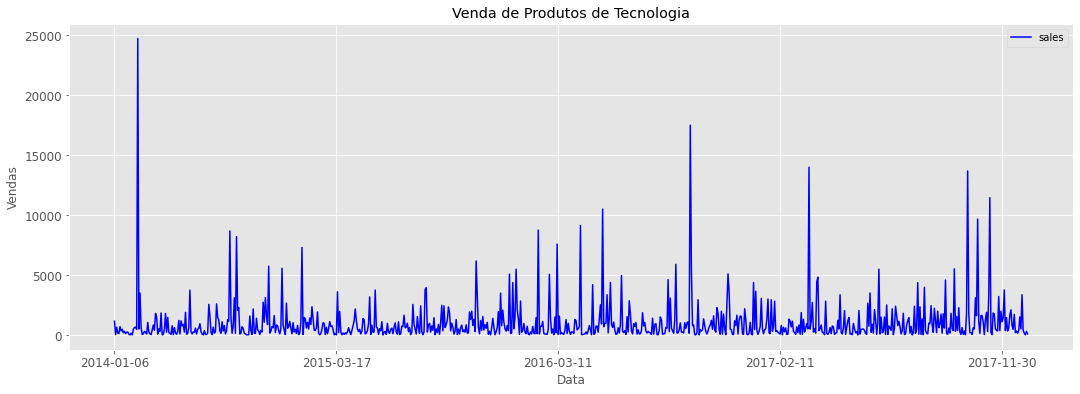

In [0]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Perceba que temos um valor realmente discrepante. Ao remover um valor discrepante estaremos perdendo informação sobre algo que realmente aconteceu (considerando que não houve erro de coleta de dados) e, portanto, é uma opção que deve ser usada com cuidado. Como não adotamos esta estratégia ainda, vamos remover e verificar se isso causa algum efeito em nosso processo. Já posso adiantar que sim, teremos uma diferença.

In [0]:
# Shape
vendas_tecnologia.sales.shape

(824,)

In [0]:
# Verificamos o valor máximo com o pico mostrado no gráfico anterior
vendas_tecnologia.sales.max()

24739.748

In [0]:
# E então gravamos no dataframe tudo que for diferente do valor máximo
vendas_tecnologia = vendas_tecnologia[vendas_tecnologia.sales != 24739.748]

In [0]:
# Shape
vendas_tecnologia.sales.shape

(823,)

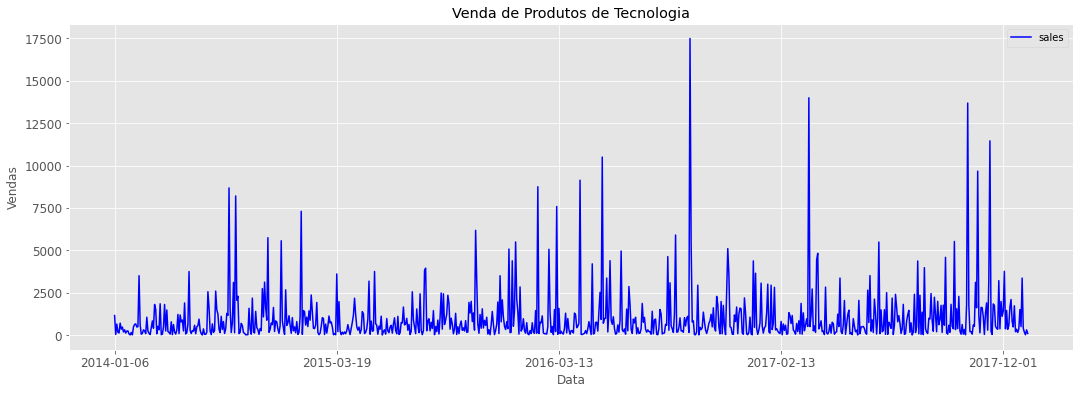

In [0]:
# Venda de Produtos de Tecnologia
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Ainda temos valores bem altos. Vamos fazer o seguinte, remover os valores maiores que 12500 no gráfico acima.

In [0]:
# Vamos checar os valores maiores que 12500
vendas_tecnologia[vendas_tecnologia.sales > 12500]

,sales
order_date,
2016-10-02,17499.950
2017-03-23,13999.960
2017-10-22,13685.258


In [0]:
# E então gravamos no dataframe tudo que for menor que 12500
vendas_tecnologia = vendas_tecnologia[vendas_tecnologia.sales < 12500]

In [0]:
# Shape
vendas_tecnologia.sales.shape

(820,)

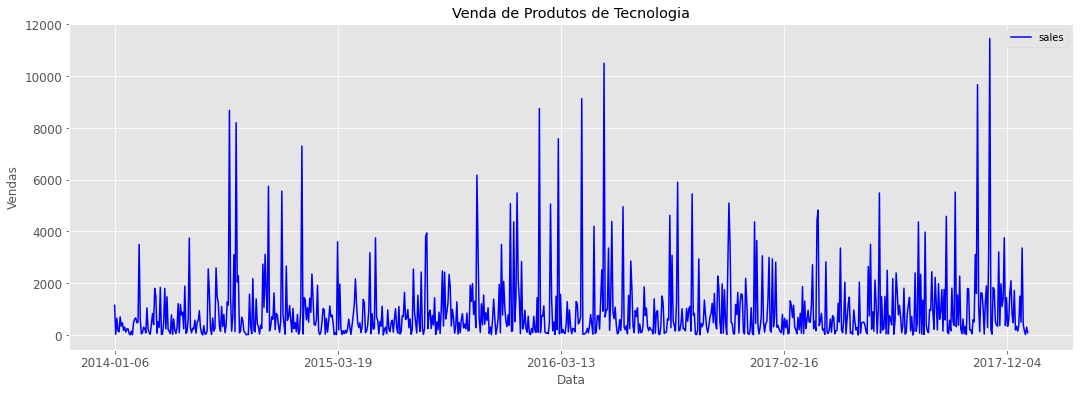

In [0]:
# Venda de Produtos de Tecnologia
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Parece melhor agora. Vamos manter assim e avaliar o resultado.

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [0]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [0]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01     518.095067
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01     935.561600
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

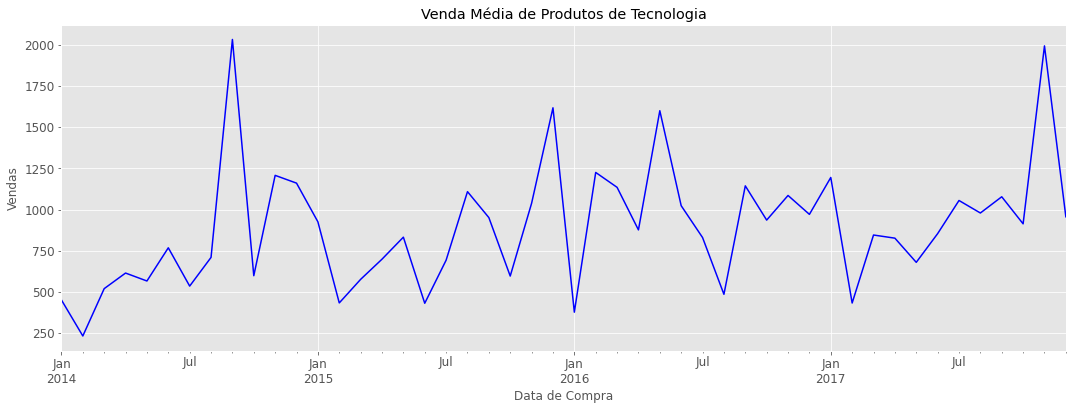

In [0]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

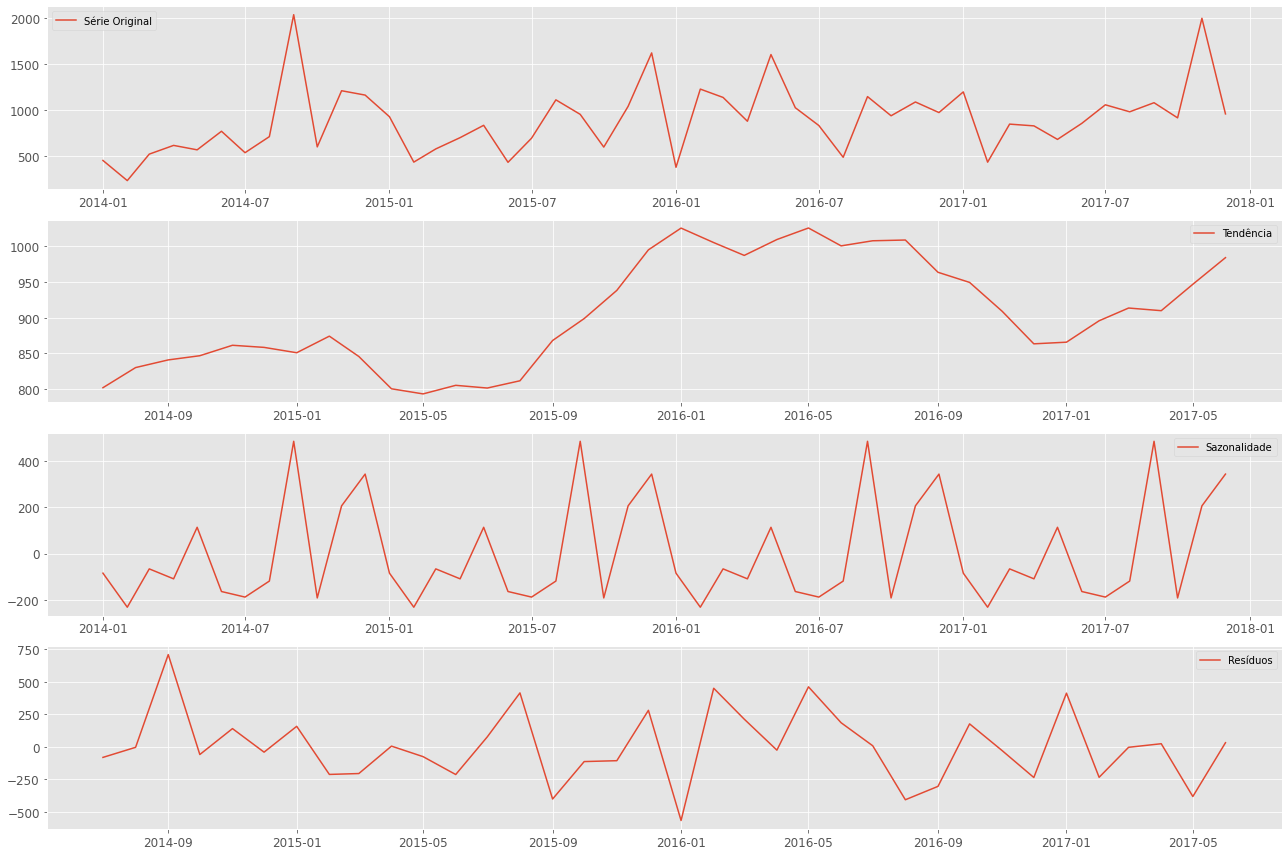

In [0]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [0]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (20, 6))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

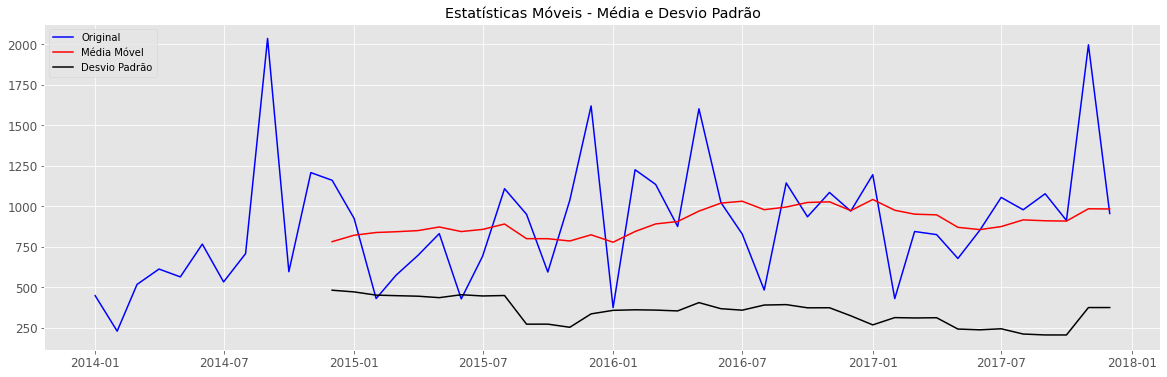


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.521421e+00
Valor-p                         1.039879e-08
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [0]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

Para a preparação dos dados, vamos alternar entre objetos NumPy e Pandas, usando o que cada um oferece de melhor. Fique atento a cada passo.

In [0]:
# Série Original
X = media_vendas_tecnologia

In [0]:
# Os primeiros 36 registros da série serão usados como dados de treino
X[:-12]

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01     518.095067
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01     935.561600
2016-11-01    1085.642360
2016-12-01     970.554870
Freq: MS, Name: sales, dtype: float64

In [0]:
# Os últimos 12 registros da série serão usados como dados de teste
X[-12:]

order_date
2017-01-01    1195.218071
2017-02-01     430.501714
2017-03-01     844.724435
2017-04-01     825.559133
2017-05-01     678.329400
2017-06-01     853.055000
2017-07-01    1054.996636
2017-08-01     978.842333
2017-09-01    1077.704120
2017-10-01     912.876429
2017-11-01    1996.750920
2017-12-01     955.865652
Freq: MS, Name: sales, dtype: float64

In [0]:
# Divisão em treino e teste
treino, teste = np.array(X[:-12]), np.array(X[-12:])

In [0]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.reshape(-1,1)
testset = teste.reshape(-1,1)

In [0]:
len(trainset)

36

In [0]:
trainset

array([[ 449.04142857],
       [ 229.78714286],
       [ 518.09506667],
       [ 613.02893333],
       [ 564.69858824],
       [ 766.90590909],
       [ 533.60893333],
       [ 708.43538462],
       [2035.83813333],
       [ 596.9009    ],
       [1208.05632   ],
       [1160.73288889],
       [ 925.0708    ],
       [ 431.12125   ],
       [ 574.66233333],
       [ 697.5595    ],
       [ 831.64285714],
       [ 429.0244    ],
       [ 691.39773333],
       [1108.90228571],
       [ 950.8564    ],
       [ 594.71611111],
       [1037.98265217],
       [1619.63763636],
       [ 374.67106667],
       [1225.8914    ],
       [1135.15010526],
       [ 875.91188235],
       [1601.81616667],
       [1023.2595    ],
       [ 829.3125    ],
       [ 483.6201    ],
       [1144.1703    ],
       [ 935.5616    ],
       [1085.64236   ],
       [ 970.55486957]])

In [0]:
len(testset)

12

In [0]:
testset

array([[1195.21807143],
       [ 430.50171429],
       [ 844.72443478],
       [ 825.55913333],
       [ 678.3294    ],
       [ 853.055     ],
       [1054.99663636],
       [ 978.84233333],
       [1077.70412   ],
       [ 912.87642857],
       [1996.75092   ],
       [ 955.86565217]])

### Função Para o Cálculo da Acurácia

In [0]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

## Modelo LSTM Bidirectional

Redes LSTMs Bidirecionais são uma extensão das LSTMs tradicionais que podem melhorar o desempenho do modelo preditivo.

Nos problemas em que todos os timesteps da sequência de entrada estão disponíveis, redes LSTMs Bidirecionais treinam duas em vez de uma rede LSTM na sequência de entrada. A primeira na sequência de entrada original e a segunda em uma cópia invertida da sequência de entrada. Isso pode fornecer um contexto adicional à rede e resultar em um aprendizado mais rápido e ainda mais completo sobre o problema.

As redes neurais recorrentes bidirecionais estão realmente apenas juntando duas RNNs independentes. A sequência de entrada é alimentada em ordem de tempo normal para uma rede e em ordem inversa para outra. As saídas das duas redes são geralmente concatenadas a cada etapa do tempo, embora existam outras opções.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [0]:
# Cria o scaler
scaler = MinMaxScaler()

In [0]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

In [0]:
trainset.shape

(36, 1)

In [0]:
trainset

array([[0.12139983],
       [0.        ],
       [0.15963443],
       [0.21219877],
       [0.18543853],
       [0.29739956],
       [0.16822437],
       [0.26502477],
       [1.        ],
       [0.20326877],
       [0.54166199],
       [0.51545928],
       [0.38497454],
       [0.11147753],
       [0.1909554 ],
       [0.25900285],
       [0.33324403],
       [0.11031652],
       [0.25559112],
       [0.48676098],
       [0.39925188],
       [0.20205906],
       [0.44749318],
       [0.76955219],
       [0.08022139],
       [0.55153717],
       [0.50129424],
       [0.35775554],
       [0.75968454],
       [0.43934106],
       [0.33195373],
       [0.14054584],
       [0.50628867],
       [0.39078324],
       [0.47388209],
       [0.41015881]])

Aqui definimos os hiperparâmetros, os mesmos que usamos anteriormente em outros modelos LSTM que criamos.

In [0]:
# Número de repetições
n_rep = 20

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 12 séries para prever as 12 séries seguintes)
n_input = 12

# Comprimento das sequências de saída (em número de timesteps)
n_output = 12

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [0]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo.

Para começar a aplicação de Deep Learning ao nosso problema criaremos um modelo básico de LSTM que chamarei de LSTM Padrão.

Aqui está a principal diferença dos modelos de Deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada da rede neural.

Como trabalharemos com batches de dados da série que serão passados pela rede várias vezes, vamos criar o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.

Nas próximas aulas ensinarei a você como definir os parâmetros da rede (como número de neurônios e dropout). Por agora, leia os comentários em cada linha de código abaixo.

In [0]:
# Criação e treinamento do modelo LSTM Padrão

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Modelo Bidirectional
    modelo_lstm.add(Bidirectional(LSTM(24, activation = 'relu'), input_shape = (12, 1)))
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = X[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 38ms/step - loss: 0.0273
Epoch 126/200
3/3 [==============================] - 0s 47ms/step - loss: 0.0273
Epoch 127/200
3/3 [==============================] - 0s 46ms/step - loss: 0.0274
Epoch 128/200
3/3 [==============================] - 0s 45ms/step - loss: 0.0273
Epoch 129/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0273
Epoch 130/200
3/3 [==============================] - 0s 46ms/step - loss: 0.0274
Epoch 131/200
3/3 [==============================] - 0s 44ms/step - loss: 0.0272
Epoch 132/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0273
Epoch 133/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0271
Epoch 134/200
3/3 [==============================] - 0s 42ms/step - loss: 0.0271
Epoch 135/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0272
Epoch 136/200
3/3 [==============================] - 0s 51ms/step - loss

Agora calculamos o erro modelo.

In [0]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [0]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [0]:
# Previsões finais
resultado_final

array([[923.35934084],
       [999.4480473 ],
       [984.11942859],
       [972.26470051],
       [999.18538636],
       [953.41201595],
       [937.70299517],
       [929.91972018],
       [981.25600482],
       [966.70450982],
       [973.37454315],
       [963.71610283]])

In [0]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((12,))

In [0]:
# Previsões finais
resultado_final

array([923.35934084, 999.4480473 , 984.11942859, 972.26470051,
       999.18538636, 953.41201595, 937.70299517, 929.91972018,
       981.25600482, 966.70450982, 973.37454315, 963.71610283])

In [0]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 130200.3
RMSE das previsões é 360.83
MAPE das previsões é 25.92


Hummm....O resultado foi muito bom! Recomendo fazer o experimento sem remover os picos de venda. O erro modelo aumenta. Ou seja, remover os picos nos permitiu aumentar a precisão do modelo. Isso causou mais impacto do que o modelo LSTM em si.


Abaixo o plot das previsões.

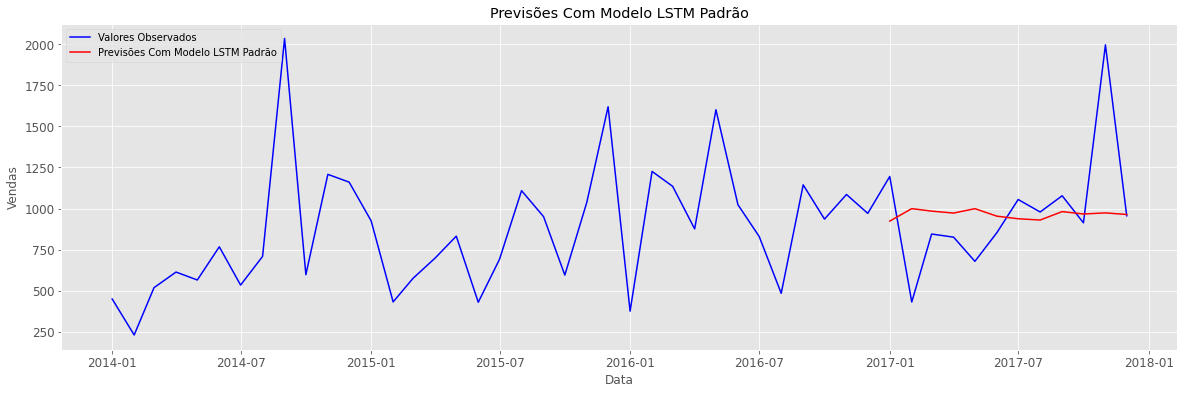

In [0]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(media_vendas_tecnologia[36:].index, 
         resultado_final,
         label = 'Previsões Com Modelo LSTM Padrão', 
         color = 'Red')

plt.title('Previsões Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Vamos fazer o Forecasting para 12 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [0]:
# Última data da série
media_vendas_tecnologia.index[-1]

Timestamp('2017-12-01 00:00:00', freq='MS')

In [0]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [media_vendas_tecnologia.index[-1] + DateOffset(months = x) for x in range(0, 13)]

In [0]:
# Visualiza as datas criadas
datas_para_prever_forecasting

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00')]

In [0]:
# Nossa série original é um objeto do tipo pd.Series
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(media_vendas_tecnologia)

In [0]:
# Visualiza os dados
df_original.head()

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,518.095067
2014-04-01,613.028933
2014-05-01,564.698588


In [0]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [0]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,sales
2018-01-01,NaN
2018-02-01,NaN
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN
2018-06-01,NaN
2018-07-01,NaN
2018-08-01,NaN
2018-09-01,NaN
2018-10-01,NaN


In [0]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [0]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [0]:
# Visualiza o dataframe
df_forecasting

,sales,Prediction
2014-01-01,449.041429,NaN
2014-02-01,229.787143,NaN
2014-03-01,518.095067,NaN
2014-04-01,613.028933,NaN
2014-05-01,564.698588,NaN
2014-06-01,766.905909,NaN
2014-07-01,533.608933,NaN
2014-08-01,708.435385,NaN
2014-09-01,2035.838133,NaN
2014-10-01,596.900900,NaN


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 12 meses que correspondem aos 12 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 12 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

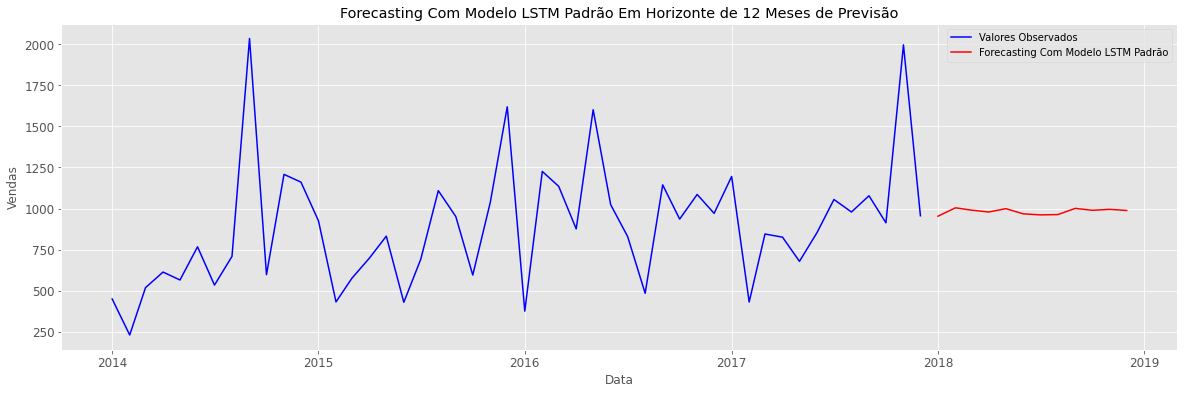

In [0]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(df_forecasting.index, 
         df_forecasting['sales'],
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(df_forecasting.index, 
         df_forecasting['Prediction'],
         label = 'Forecasting Com Modelo LSTM Padrão', 
         color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Por que a linha vermelha do forecast é quase uma linha reta? Porque nosso modelo fez o que pedimos a ele. Aprendeu sobre as previsões das médias mensais de vendas. O maior problema nesse caso é que não capturamos os valores altos e baixos, mas somente a média. Por isso trabalhar com séries mensais é muito complicado e o ideal é mesmo usar séries diárias, como usaremos nas aulas finais do curso.

Mas não acabou. Vamos tentar otimizar os hiperparâmetros.

## Grid Search

Grid Search é o processo de executar o ajuste de hiperparâmetros para determinar os valores ideais para um modelo. Isso é significativo, pois o desempenho de todo o modelo é baseado nos valores de hiperparâmetros especificados.

Se você trabalha com Machine Learning, sabe como é um difícil estipular valores para hiperparâmetros. Encontrar a combinação ideal é muito complicado e o Grid Search é uma forma de automatizar o processo.

Vamos criar algumas funções e então testar diversas combinações de hiperpaâmetros. Leia os comentários para compreender o que está sendo feito em cada etapa.

**Tratando a Série Como um Dataset de Aprendizagem Supervisionada**

Precisamos ser capazes de enquadrar a série univariada de observações como um problema de aprendizado supervisionado, para que possamos usar Grid Search.

Um enquadramento de aprendizado supervisionado de uma série significa que os dados precisam ser divididos em vários exemplos com os quais o modelo aprende e generaliza.

Cada amostra deve ter um componente de entrada e um componente de saída.

O componente de entrada será um número de observações anteriores, como três anos ou 36 etapas de tempo.

O componente de saída será o total de vendas no próximo mês, porque estamos interessados em desenvolver um modelo para fazer previsões em uma etapa.

Podemos implementar isso usando a função shift() no DataFrame do pandas. Isso nos permite deslocar uma coluna para baixo (para frente no tempo) ou para trás (para trás no tempo). Podemos tomar a série como uma coluna de dados e, em seguida, criar várias cópias da coluna, avançar ou retroceder no tempo, a fim de criar as amostras com os elementos de entrada e saída necessários.

Quando uma série é alterada para baixo, os valores de NaN são introduzidos porque não temos valores além do início da série e então valores NaN devem ser removidos.

In [0]:
# Transforma a série em formato para aprendizagem supervisionada com dados de entrada e saída
# Como temos uma série temporal, o que fazemos é pegar um pasos no tempo da série 
# (por exemplo a venda média de Janeiro) e chamar de x e o próximo passo de tempo (venda média de Fevereiro) 
# chamamos de y. E fazemos isso em toda a série, por isso o shift (deslocamento) no código abaixo.

def transforma_serie(dados, num_input = 1, num_output = 1):
    
    # Converte os dados em formato dataframe do Pandas
    df = pd.DataFrame(dados)
    
    # Lista de colunas
    cols = list()
    
    # Loop para definir os dados de entrada
    for i in range(num_input, 0, -1):
        cols.append(df.shift(i))
        
    # Loop para definir os dados de saída    
    for i in range(0, num_output):
        cols.append(df.shift(-i))
    
    # Concatena entrada e saída em um único dataframe
    dataset_final = pd.concat(cols, axis = 1)
    
    # Remove valores NA
    dataset_final.dropna(inplace = True)
    
    return dataset_final.values

A função abaixo aplica a diferenciação à série, conforme o que estudamos em outras aulas e conforme o que for passado como parâmetro de ordem.

In [0]:
# Função para diferenciação do dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

A função abaixo divide os dados de treino em treino e validação.

In [0]:
# Separa os dados de treino em treino e validação
def divide_treino_valid(dados, num):
    return dados[:-num], dados[-num:]

A próxima função será usada para treinar o modelo com as diferentes combinações de hiperparâmetros.

In [0]:
# Função para treinar o modelo
def treina_modelo(train, config):
    
    # Hiperparâmetros para o modelo
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # Checa se devemos aplicar a diferenciação
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # Transforma a série em formato de aprendizagem supervisionada
    data = transforma_serie(train, num_input = n_input)
    
    # Separa x e y
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # Reshape dos dados para o formato [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    
    # Define o modelo
    model = Sequential()
    model.add(Bidirectional(LSTM(n_nodes, activation = 'relu', input_shape = (n_input, n_features))))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mse')
    
    # Treinamento
    model.fit(train_x, train_y, epochs = n_epochs, batch_size = n_batch, verbose = 0)
    
    return model

Se temos função ara treinar o modelo precisamos de uma para fazer as previsões com o modelo treinado. É o que temos abaixo.

In [0]:
# Função para as previsões do modelo
def previsao_serie(model, history, config):
    
    # Extrai somente os hiperparâmetros de interesse
    # Os sinais _ absorvem o retorno da função que não é do nosso interesse neste momento
    n_input, _, _, _, n_diff = config
    
    # Prepara os dados
    correction = 0.0
    
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    
    # Reshape dos dados no formato [samples, timesteps, features]
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    
    # Previsão
    yhat = model.predict(x_input, verbose = 0)
    
    return correction + yhat[0]

Os modelos de previsão de séries temporais podem ser avaliados em um conjunto de testes usando a validação Walk-forward.

A validação Walk-forward é uma abordagem em que o modelo faz uma previsão para cada observação no conjunto de dados de teste, uma de cada vez. Depois que cada previsão é feita para uma etapa no conjunto de dados de teste, a observação verdadeira para a previsão é adicionada ao conjunto de dados de teste e disponibilizada ao modelo.

Modelos mais simples podem ser reajustados com a observação antes de fazer a previsão subsequente. Modelos mais complexos, como redes neurais, não são reajustados, dado o custo computacional muito maior.

No entanto, a observação verdadeira para o intervalo de tempo pode ser usada como parte da entrada para fazer a previsão no próximo intervalo de tempo.

Primeiro, o conjunto de dados é dividido em conjuntos de treino e teste. 

Um modelo será ajustado uma vez no conjunto de dados de treinamento para uma determinada configuração.

Definiremos uma função genérica para executar esta operação que pode ser preenchida para o tipo de rede neural que nos interessa mais tarde. A função pega o conjunto de dados de treinamento e a configuração do modelo e retorna o modelo ajustado pronto para fazer previsões.

In [0]:
# Validação Walk-forward para dados univariados
def walk_forward_validation(data, n_test, cfg):
    
    # Lista para as previsões
    predictions = list()
    
    # Divide o dataset
    train, valid = divide_treino_valid(data, n_test)
    
    # Treinao o modelo
    model = treina_modelo(train, cfg)
    
    # Grava o histórico
    history = [x for x in train]
    
    # Um passo para frente com os dados de validação
    for i in range(len(valid)):
        
        # Faz a previsão
        yhat = previsao_serie(model, history, cfg)
        
        # Armazena a previsão
        predictions.append(yhat)
        
        # Armazena o histórico
        history.append(valid[i])
    
    # Estima o erro de previsão
    erro =  math.sqrt(mean_squared_error(valid, predictions))
    print('\n')
    print('Erro estimado para o modelo = %.3f' % erro)
    return erro

A função abaixo avalia o modelo.

In [0]:
# Avalia o modelo
def avalia_modelo(data, config, n_test, n_repeats = 10):
    
    # Gera a lista de hiperparâmetros
    key = str(config)
    
    # Treina e avalia o modelo
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    # Sore
    result = np.mean(scores)
    print('\n')
    print('Erro do Modelo com Hiperparâmetros [%s] é igual a %.3f' % (key, result))
    return (key, result)

Função para o Grid Search.

In [0]:
# Função para o Grid Search
def grid_search(data, cfg_list, n_test):
    
    # Gera os scores
    scores = [avalia_modelo(data, cfg, n_test) for cfg in cfg_list]
    
    # Ordena os hiperparâmetros pelo erro
    scores.sort(key = lambda tup: tup[1])
    return scores

Aqui listamos os hiperparâmetros que queremos testar. Colocamos apenas algumas combinações pois o processo é demorado. Fique à vontade para testar outras combinações.

In [0]:
# Lista de hiperparâmetros que serão testados
def lista_hiperparametros():
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [50, 100, 200]
    n_batch = [5, 10]
    n_diff = [12]
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
                        
    print('\nTotal de Combinações de Hiperparâmetros: %d' % len(configs))
    return configs

In [0]:
# Define o dataset (estamos usando os dados já normalizados)
data = trainset

In [0]:
# Split
n_test = 1

In [0]:
# Lista de hiperparâmetros
cfg_list = lista_hiperparametros()


Total de Combinações de Hiperparâmetros: 12


In [0]:
# Grid Search
scores = grid_search(data, cfg_list, n_test)
print('Concluído.')



Erro estimado para o modelo = 0.405


Erro estimado para o modelo = 0.383


Erro estimado para o modelo = 0.368


Erro estimado para o modelo = 0.427


Erro estimado para o modelo = 0.399


Erro estimado para o modelo = 0.383


Erro estimado para o modelo = 0.420


Erro estimado para o modelo = 0.408


Erro estimado para o modelo = 0.432


Erro estimado para o modelo = 0.376


Erro do Modelo com Hiperparâmetros [[12, 50, 50, 5, 12]] é igual a 0.400


Erro estimado para o modelo = 0.458


Erro estimado para o modelo = 0.423


Erro estimado para o modelo = 0.435


Erro estimado para o modelo = 0.492


Erro estimado para o modelo = 0.430


Erro estimado para o modelo = 0.407


Erro estimado para o modelo = 0.432


Erro estimado para o modelo = 0.464


Erro estimado para o modelo = 0.443


Erro estimado para o modelo = 0.446


Erro do Modelo com Hiperparâmetros [[12, 50, 50, 10, 12]] é igual a 0.443


Erro estimado para o modelo = 0.282


Erro estimado para o modelo = 0.325


Erro estima

In [0]:
# Lista do resultado
print('\nAqui estão os hiperparâmetros que apresentaram os melhores resultados:')
for cfg, error in scores[:3]:
    print(cfg, error)


Aqui estão os hiperparâmetros que apresentaram os melhores resultados:
[12, 100, 200, 5, 12] 0.08451885460300641
[12, 50, 200, 5, 12] 0.13828488002668013
[12, 100, 100, 5, 12] 0.26661295864648604


Agora que temos os melhores hiperparâmetros, vamos criar a versão final do modelo.

In [0]:
# Lista de hiperparâmetros com melhor performance: n_input, n_nodes, n_epochs, n_batch, n_diff 
config = [12, 100, 200, 5, 12]

Em relação ao nosso modelo, somente 2 hiperparâmetros devem ser modificados: número de nodes (vamos aumentar de 24 para 100) e tamanho do batch (vamos reduzir de 10 para 5). O restante se mantém igual.

In [0]:
# Número de repetições
n_rep = 20

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 12 séries para prever as 12 séries seguintes)
n_input = 12

# Comprimento das sequências de saída (em número de timesteps)
n_output = 12

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 5

In [0]:
# Criação e treinamento do modelo LSTM Padrão

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Modelo Bidirectional
    modelo_lstm.add(Bidirectional(LSTM(100, activation = 'relu'), input_shape = (12, 1)))
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = X[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 42ms/step - loss: 0.0276
Epoch 126/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0281
Epoch 127/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0278
Epoch 128/200
3/3 [==============================] - 0s 56ms/step - loss: 0.0279
Epoch 129/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0277
Epoch 130/200
3/3 [==============================] - 0s 45ms/step - loss: 0.0280
Epoch 131/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0279
Epoch 132/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0276
Epoch 133/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0275
Epoch 134/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0275
Epoch 135/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0280
Epoch 136/200
3/3 [==============================] - 0s 57ms/step - loss

Vamos calcular o erro do modelo.

In [0]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [0]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [0]:
# Previsões finais
resultado_final

array([[ 829.79285261],
       [ 985.62431355],
       [ 973.17335519],
       [ 968.54508751],
       [1019.97487609],
       [ 953.09136986],
       [ 926.50104542],
       [ 890.58624293],
       [ 993.68605235],
       [ 967.66459382],
       [ 974.50833231],
       [ 960.10262639]])

In [0]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((12,))

In [0]:
# Previsões finais
resultado_final

array([ 829.79285261,  985.62431355,  973.17335519,  968.54508751,
       1019.97487609,  953.09136986,  926.50104542,  890.58624293,
        993.68605235,  967.66459382,  974.50833231,  960.10262639])

In [0]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 132553.55
RMSE das previsões é 364.08
MAPE das previsões é 25.86


E aí está. Quase o mesmo resultado da primeira versão, mas um modelo bem estável.

Abaixo o plot das previsões.

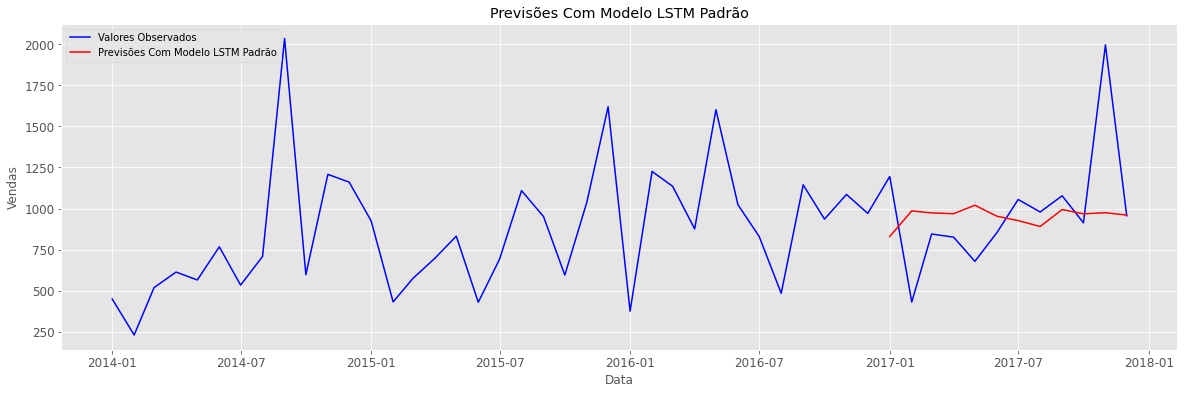

In [0]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(media_vendas_tecnologia[36:].index, 
         resultado_final,
         label = 'Previsões Com Modelo LSTM Padrão', 
         color = 'Red')

plt.title('Previsões Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Vamos fazer o Forecasting para 12 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [0]:
# Última data da série
media_vendas_tecnologia.index[-1]

Timestamp('2017-12-01 00:00:00', freq='MS')

In [0]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [media_vendas_tecnologia.index[-1] + DateOffset(months = x) for x in range(0, 13)]

In [0]:
# Visualiza as datas criadas
datas_para_prever_forecasting

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00')]

In [0]:
# Nossa série original é um objeto do tipo pd.Series
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(media_vendas_tecnologia)

In [0]:
# Visualiza os dados
df_original.head()

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,518.095067
2014-04-01,613.028933
2014-05-01,564.698588


In [0]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [0]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,sales
2018-01-01,NaN
2018-02-01,NaN
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN
2018-06-01,NaN
2018-07-01,NaN
2018-08-01,NaN
2018-09-01,NaN
2018-10-01,NaN


In [0]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [0]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [0]:
# Visualiza o dataframe
df_forecasting

,sales,Prediction
2014-01-01,449.041429,NaN
2014-02-01,229.787143,NaN
2014-03-01,518.095067,NaN
2014-04-01,613.028933,NaN
2014-05-01,564.698588,NaN
2014-06-01,766.905909,NaN
2014-07-01,533.608933,NaN
2014-08-01,708.435385,NaN
2014-09-01,2035.838133,NaN
2014-10-01,596.900900,NaN


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 12 meses que correspondem aos 12 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 12 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

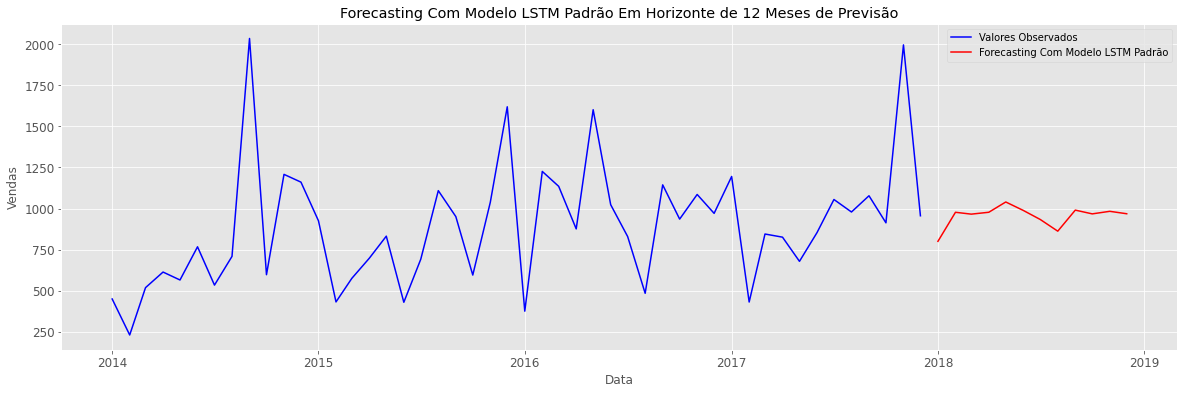

In [0]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(df_forecasting.index, 
         df_forecasting['sales'],
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(df_forecasting.index, 
         df_forecasting['Prediction'],
         label = 'Forecasting Com Modelo LSTM Padrão', 
         color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

E aí está nosso modelo de Deep Learning para previsão de séries temporais! Conseguimos colocar essa versão do modelo entre o Top5 dos modelos que criamos até aqui. Mas dada a natureza da série que estamos usando, o Prophet foi imbatível.

Se treinarmos o modelo acima por um período maior, talvez tenhamos um resultado ainda mais interessante. Você pode tentar isso se desejar.

Resumindo o que fizemos nesta aula:
    
- Removemos os picos de vendas da série original.
- Criamos a primeira versão do modelo LSTM Bidirectional (que teve boa performance).
- Executamos o Grid Search para buscar os melhores hiperparâmetros.
- Criamos a versão final do modelo com os melhores hiperparâmetros.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45
- Aula 22 --> Modelo LSTM Padrão - RMSE = 397.12 e MAPE = 31.46
- Aula 23 --> Modelo Stacked LSTM - RMSE = 396.24 e MAPE = 36.35
- Aula 24 --> Modelo Stacked LSTM Profundo - RMSE = 504.52 e MAPE = 46.35
- Aula 25 --> Modelo Bidirectional LSTM - RMSE = 363.98 e MAPE = 26.15


Até a próxima aula.

# Fim